In [2]:
# Import libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import os, os.path as osp

import nltk  #to install: activate ada,   conda install -c anaconda nltk
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from ast import literal_eval
#nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import string

In [3]:
#Import CSV
DATA_FOLDER='data/data_1_5'
df1=pd.read_csv(DATA_FOLDER+'/recipes_data1.csv') # Normalized Carbon footprint
df2=pd.read_csv(DATA_FOLDER+'/recipes_data2.csv') # Serving size in extra column
df3=pd.read_csv(DATA_FOLDER+'/recipes_data3.csv')
df4=pd.read_csv(DATA_FOLDER+'/recipes_data4.csv')
df5=pd.read_csv(DATA_FOLDER+'/recipes_data5.csv')

df=pd.concat([df2,df3,df4,df5], sort=False) #MISSING DF1
df.head(5)

,Recipe Title,Has meat,Meat types,Meat quantity (kg),Carbon footprint,Rating,Website,Servings
0,\r\n\tCaramelized Red Bell Peppers and Onions ...,False,[],0,0.000000,4.5,allrecipes,4 servings
1,\r\n\tMichele's Ground Beef Casserole Recipe -...,True,"['beef', 'cheese']","[0.4535147392290249, 0]",12.244898,5.0,allrecipes,6 servings
2,\r\n\tHerbed Cream Cheese Omelet Recipe - Allr...,True,"['cheese', 'egg']","[0.11339797017633384, 0.048]",1.761273,4.0,allrecipes,4 servings
3,Breadsticks Recipe : Wolfgang Puck : Recipes :...,False,[],0,0.000000,5.0,food network,4 servings\t\t
4,\r\n\tPaul's Pumpkin Bars Recipe - Allrecipes....,True,"['egg', 'cheese']","[0.024, 0.11339797017633384]",1.646073,4.7,allrecipes,2 dozen


### Data Cleaning
Although we did most of the data cleaning in the previous notebook, we still need to clean out titles from the CSV file, annd remove outliers or other discrepancies that arose when analysing the data from our csv file.

In [4]:
def normalize_servings(c_f, servs):
    #input is ingredient quantity in kg
    #interpret servings as a total quantity using the check_quantity function
    tot_servs = servs.str.extract('(\d+)') #find value
    tot_servs=tot_servs.fillna(value='2') #replace missing values with 2
    tot_servs=tot_servs.astype(int) #convert to int
    c_f_norm=c_f/tot_servs[0]
    return c_f_norm

In [5]:
df['Carbon footprint']=normalize_servings(df['Carbon footprint'],df['Servings'])

In [6]:
#Remove the '\n', '\r' and '\t' left out of the DF -> CSV -> DF conversion
df_cleaned = df.copy()
df_cleaned['Recipe Title'] = df_cleaned['Recipe Title'].str.replace('\n', '')\
                                                        .str.replace('\t', '')\
                                                        .str.replace('\r', '')

df_cleaned['Servings'] = df_cleaned['Servings'].str.replace('\n', '')\
                                                .str.replace('\t', '')\
                                                .str.replace('\r', '')

#remove incoherent values (inf) in carbon footprint
df_cleaned['Carbon footprint'] = df_cleaned['Carbon footprint'].replace([np.inf, np.nan], 0)

In [7]:
df_cleaned.head(5)

,Recipe Title,Has meat,Meat types,Meat quantity (kg),Carbon footprint,Rating,Website,Servings
0,Caramelized Red Bell Peppers and Onions Recipe...,False,[],0,0.000000,4.5,allrecipes,4 servings
1,Michele's Ground Beef Casserole Recipe - Allre...,True,"['beef', 'cheese']","[0.4535147392290249, 0]",2.040816,5.0,allrecipes,6 servings
2,Herbed Cream Cheese Omelet Recipe - Allrecipes...,True,"['cheese', 'egg']","[0.11339797017633384, 0.048]",0.440318,4.0,allrecipes,4 servings
3,Breadsticks Recipe : Wolfgang Puck : Recipes :...,False,[],0,0.000000,5.0,food network,4 servings
4,Paul's Pumpkin Bars Recipe - Allrecipes.com,True,"['egg', 'cheese']","[0.024, 0.11339797017633384]",0.823036,4.7,allrecipes,2 dozen


In [8]:
#sort dataframe
df_sorted_meat = df_cleaned.sort_values(['Carbon footprint'], ascending=False).reset_index(drop=True)

#remove all non-meat ingredients
df_sorted_meat = df_sorted_meat[df_sorted_meat['Has meat'] == True]

#remove infinite and NaN values
df_sorted_meat = df_sorted_meat.replace([np.inf, np.nan], 0)

In [7]:
df_sorted_meat.head(5)

,Recipe Title,Has meat,Meat types,Meat quantity (kg),Carbon footprint,Rating,Website,Servings
0,Allspice Gravy Recipe : Nigella Lawson : Recip...,True,"['turkey', 'turkey', 'turkey']","[0, 0, 30.25]",329.725000,5.0,food network,1 liter
1,Manny's Manly Meat Sauce Recipe : Rachael Ray ...,True,"['beef', 'beef']","[41.269841269841265, 0]",278.571429,4.0,food network,4 large servings
2,Beef Taco Salad with Chunky Tomato Dressing Re...,True,['beef'],[41.156462585034014],277.806122,5.0,food network,4 servings
3,Salisbury Steak Dinner Recipe from Betty Crocker,True,"['egg', 'beef', 'beef']","[0.006, 36.73469387755102, 0.368543403073085]",250.454052,0.0,betty crocker,4 servings
4,Bo Burger Recipe : Paula Deen : Recipes : Food...,True,"['beef', 'egg', 'cheese']","[36.961451247165535, 0.024, 0]",249.518596,5.0,food network,4 servings


### Data exploration and basic analysis


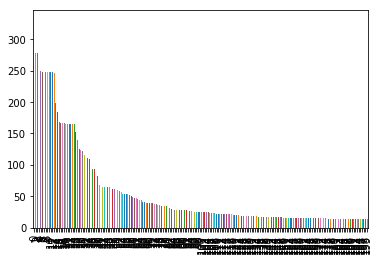

In [9]:
#Lets plot the biggest impact recipes
df_sorted_meat['Carbon footprint'].head(200).plot(kind='bar',y='Carbon footprint')

We can see the biggest impact recipes have a carbon footprint orders of magnitude above the other recipes' footprint; the tailof the distribution flattens out in the end.

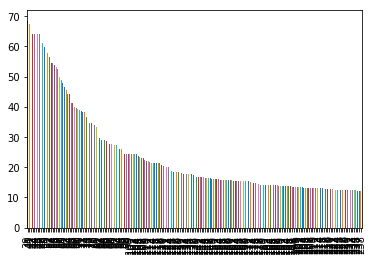

In [10]:
#remove recipes with a zero score and those with an anormally high footprint
df_sorted_meat_cropped = df_sorted_meat[(df_sorted_meat['Carbon footprint'] >= 0.1) & (df_sorted_meat['Carbon footprint'] <= 70)]

#Lets plot again the biggest impact recipes
df_sorted_meat_cropped['Carbon footprint'].head(200).plot(kind='bar',y='Carbon footprint')

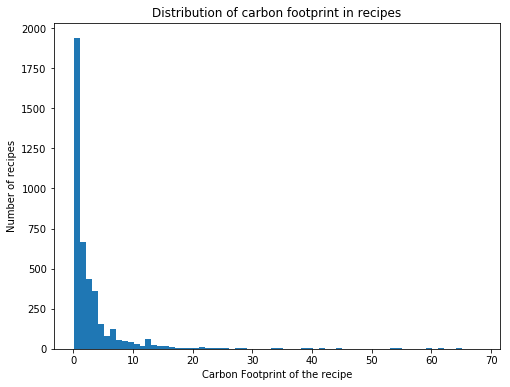

In [11]:
# Plot the distribution of carbon footprint
binwidth = 1
min_val  = min(df_sorted_meat_cropped['Carbon footprint'])
max_val = max(df_sorted_meat_cropped['Carbon footprint'])
ticks = np.arange(min_val,max_val,binwidth)

plt.figure(figsize=(8,6))
plt.hist(df_sorted_meat_cropped['Carbon footprint'], bins=np.arange(min_val, max_val, binwidth))

plt.xlabel('Carbon Footprint of the recipe')
plt.ylabel('Number of recipes')
plt.title('Distribution of carbon footprint in recipes')
plt.show()

We can see that even applying a threshold on the lower value of the carbon footprint (here 100g per recipe), we still have a distribution with a long tail. We can try plotting the data on a logarithmic scale

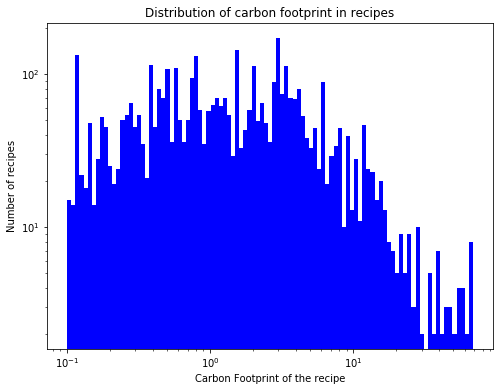

In [12]:
# Plot the distribution of carbon footprint
bins = 100
min_val  = min(df_sorted_meat_cropped['Carbon footprint'])
max_val = max(df_sorted_meat_cropped['Carbon footprint'])
ticks = np.arange(min_val,max_val,bins)

plt.figure(figsize=(8,6))

logbins=np.logspace(np.log10(min_val),np.log10(max_val),bins)
plt.hist(df_sorted_meat_cropped['Carbon footprint'], bins=logbins,color='blue')
                    
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Carbon Footprint of the recipe')
plt.ylabel('Number of recipes')
plt.title('Distribution of carbon footprint in recipes')
plt.show()

### Assumptions
We assume we can assign a "median" carbon footprint value to all recipes in which we detected meat ingredients but couldn't extract a meat quantity. 

In [13]:
meat_products = ['lamb', 'beef', 'cheese', 'pork', 'turkey', 'chicken', 'tuna', 'egg']

In [14]:
#Re-map the dataframe to one with columns with quantities and carbon footprints for every meat ingredient
meat_qty = df_sorted_meat.copy()
meat_qty.head(5)

,Recipe Title,Has meat,Meat types,Meat quantity (kg),Carbon footprint,Rating,Website,Servings
0,Allspice Gravy Recipe : Nigella Lawson : Recip...,True,"['turkey', 'turkey', 'turkey']","[0, 0, 30.25]",329.725000,5.0,food network,1 liter
1,Manny's Manly Meat Sauce Recipe : Rachael Ray ...,True,"['beef', 'beef']","[41.269841269841265, 0]",278.571429,4.0,food network,4 large servings
2,Beef Taco Salad with Chunky Tomato Dressing Re...,True,['beef'],[41.156462585034014],277.806122,5.0,food network,4 servings
3,Salisbury Steak Dinner Recipe from Betty Crocker,True,"['egg', 'beef', 'beef']","[0.006, 36.73469387755102, 0.368543403073085]",250.454052,0.0,betty crocker,4 servings
4,Bo Burger Recipe : Paula Deen : Recipes : Food...,True,"['beef', 'egg', 'cheese']","[36.961451247165535, 0.024, 0]",249.518596,5.0,food network,4 servings


In [18]:
def meat_quantities(recipe_data):
    '''
    Input: recipe dataframe row. Output: meat quantity dataframe.
    Reads and converts the list of meat ingredients and quantities from string to values then creates
    and returns a DataFrame with all meat quantitities per meat type.
    '''
    columns = literal_eval(recipe_data['Meat types'])
    rows = literal_eval(recipe_data['Meat quantity (kg)'])    
    df = pd.DataFrame(np.array(rows).reshape(1,len(rows)), columns=columns)

    for meat in meat_products:
        if meat in columns:
            df[meat] = pd.DataFrame(df[meat]).sum(axis=1)
            
    df = df.T.drop_duplicates().T.reindex(labels=meat_products, axis='columns')
    return df

def meat_quantities_df(dataframe, assign_median=False):
    
    meat_qty_df = pd.DataFrame(columns=meat_products)
    c=0

    for i in np.arange(len(dataframe)):
        try:
            new_row = meat_quantities(dataframe.iloc[i])

            for meat in meat_products:
                if ((assign_median == True) & (new_row[meat].iloc[0] != np.nan) & (new_row[meat].iloc[0] <= 0.01)):
                    new_row[meat] = meat_medians[meat]
                    
            meat_qty_df = pd.concat([meat_qty_df,new_row], sort=True)
        except:
            c = c+1
            pass

    print('exception count: '+str(c))
    
    if (assign_median == True):
        meat_qty_df = meat_qty_df.replace(np.nan, 0)
    
    return meat_qty_df.reset_index(drop=True)

In [19]:
#We extract the meat quantities for all recipes having quantities extracted (not the zero values)
df_sorted_meat2 = df_sorted_meat.copy()
meat_qty_df = meat_quantities_df(df_sorted_meat2[df_sorted_meat2['Carbon footprint'] >= 0.01])

#Now we can extract the median and mean amounts of meat ingredients in recipes
meat_medians = meat_qty_df.median(axis='rows', skipna=True)
meat_means = meat_qty_df.mean(axis='rows', skipna=True)

print(meat_medians)

exception count: 189
beef       0.680272
cheese     0.226757
chicken    0.453515
egg        0.018000
lamb       0.907029
pork       0.680272
tuna       0.226796
turkey     0.680272
dtype: float64


In [21]:
meat_qty_df

,beef,cheese,chicken,egg,lamb,pork,tuna,turkey
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.25
1,41.269841,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,41.156463,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,37.103237,NaN,NaN,0.0060,NaN,NaN,NaN,NaN
4,36.961451,0.000000,NaN,0.0240,NaN,NaN,NaN,NaN
5,36.734694,0.141747,NaN,0.0060,NaN,NaN,NaN,NaN
6,36.734694,0.141747,NaN,NaN,NaN,NaN,NaN,NaN
7,36.734694,0.106311,NaN,NaN,NaN,NaN,NaN,NaN
8,36.734694,NaN,NaN,0.0060,NaN,NaN,NaN,NaN
9,36.734694,NaN,NaN,0.0060,NaN,NaN,NaN,NaN


In [22]:
#Assign this median value to all zeroes in meat quantities
meat_qty_all = meat_quantities_df(df_sorted_meat2, assign_median=True)
meat_qty_all.head(-10)

exception count: 199


,beef,cheese,chicken,egg,lamb,pork,tuna,turkey
0,0.000000,0.000000,0.000000,0.000,0.0,0.000000,0.000000,30.25
1,41.269841,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.00
2,41.156463,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.00
3,37.103237,0.000000,0.000000,0.018,0.0,0.000000,0.000000,0.00
4,36.961451,0.226757,0.000000,0.024,0.0,0.000000,0.000000,0.00
5,36.734694,0.141747,0.000000,0.018,0.0,0.000000,0.000000,0.00
6,36.734694,0.141747,0.000000,0.000,0.0,0.000000,0.000000,0.00
7,36.734694,0.106311,0.000000,0.000,0.0,0.000000,0.000000,0.00
8,36.734694,0.000000,0.000000,0.018,0.0,0.000000,0.000000,0.00
9,36.734694,0.000000,0.000000,0.018,0.0,0.000000,0.000000,0.00


In [ ]:
#Group meat quantities per meat type

### Clustering 

In [ ]:

#remove website and meat value from title (NEEDED FOR CLUSTERING)
def tolkenize_title(title_str, recipe_site):
    """
    
    input:
    title_str = full recipe title
    recipe_site = website where recipe is from
    output:
    word_tokens = only the relevant keywords from the title (excluding website, stopwords, punctuation and meat keywords)
    
    """
    #make title lowercase
    title_str=title_str.casefold()
    
    #remove recipe site
    title_str=re.sub(recipe_site,'',title_str)
    title_str=re.sub('.com', '',title_str)
    title_str=re.sub('recipe', '',title_str)
    if 'betty' in title_str: #betty crocker has the form 'bettycrocker' and 'betty crocker'
        title_str=re.sub('bettycrocker','', title_str)
        
    #remove meat products from title to avoid clustering meat with meat....MAYBE WE SHOULDN'T DO THIS..?
    for i in meat_products:
        title_str=re.sub(i, '',title_str)
    
    #remove punctuation
    title_str="".join((char for char in title_str if char not in string.punctuation))

    stop_words=set(stopwords.words('english'))
    word_tokens = word_tokenize(title_str)
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    
    #print('word tokens=',word_tokens) 
    #print('filtered sentence = ',filtered_sentence) 
    #print('title str = ',title_str)

    return filtered_sentence

tolkenize_title('the Simple Collard Chicken of !! Greens Recipe | BettyCrocker.com', 'betty crocker')
    
    
    

In [ ]:
#transfer corpus into vector space

#calculating distance between each title as a measure of similarity

#clustering the documents using the k-means algorithm


#using multidimensional scaling to reduce dimensionality within the corpus
